In [436]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from skimage.feature import hog
import os
import random
import time
import glob
from sklearn.externals import joblib
import pickle


class VehicleTracker():
    def __init__(self, spatial_size=(8, 8), color_param=([0,1,2], 32), 
                 hog_param=(0, 5, 8, 2), use_spatial=True, use_color_hist=True, use_hog=True):
        self.spatial_size = spatial_size
        self.color_channels = color_param[0]
        self.color_bins = color_param[1]
        self.hog_channel = hog_param[0]
        self.hog_orient = hog_param[1]
        self.hog_pix = hog_param[2]
        self.hog_cells = hog_param[3]
        self.hog_transform = False
        self.use_spatial = use_spatial
        self.use_color_hist = use_color_hist
        self.use_hog = use_hog
        self.clf_size = (64, 64)
        self.heat_map_threshold = 2
        self.ystart = 380
        self.ystop = 670
        self.clf = None
        self.X_scaler = None
        self.search_windows = self.window_gen(0, 1280, self.ystop-self.ystart, 64, 2, windows = [])
        
    def __str__(self):
        print_string = ("Vehicle Detection Parameters\n" +
                        "Spatial:\t%r\n" % self.use_spatial +
                        "  Spatial Size:\t%s\n" % (self.spatial_size,) +
                        "Color:\t\t%r\n" % self.use_color_hist +
                        "  Channels:\t%s\n" % self.color_channels +
                        "  Bins:\t\t%i\n" % self.color_bins +
                        "HOG:\t\t\t%r\n" % self.use_hog +
                        "  Channel:\t\t%i\n" % self.hog_channel +
                        "  Orientations:\t\t%i\n" % self.hog_orient +
                        "  Pixels per Cell:\t%i\n" % self.hog_pix +
                        "  Cells per Block:\t%i\n" % self.hog_cells +
                        "  Sqrt Transform:\t%r\n" % self.hog_transform +
                        "Window\n" +
                        "  Start:\t%i\n" % self.ystart +
                        "  Stop:\t\t%i\n" % self.ystop +
                        "Classifier:\t" + str(vt.clf)[:9] + "\n" +
                        "  Scaler:\t %s\n" + str(vt.X_scaler)[:14] + 
                        "  Size:\t\t%s\n" % (self.clf_size,) +
                        "  Heat Threshold: %i\n" % self.heat_map_threshold +
                        "Search Windows:\t%i" % len(self.search_windows)
                       )
        return print_string
        
    def convert_to_LUV(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    def get_spatial_feature(self, img):
        return cv2.resize(img, self.spatial_size).ravel()
    
    def get_color_feature(self, img):
        """ Color histogram feature of image.  Range is set for standard 0 to 256 image.
        Channels to extract histogram from is stored in color_channels
        Number of bins in the histogram is stored in color_bins
        img -- image to obtain histogram feature
        return -- single, concatenated array of histogram bin values
        """
        color_features = []
        for channel in self.color_channels:
            channel_hist, _ = np.histogram(img[:,:,channel], bins=self.color_bins, range=(0,256), density=False)
            color_features.append(channel_hist)
        if len(self.color_channels) > 1:
            color_features = np.concatenate(color_features)
        return np.ravel(color_features)
    
    def generate_hog(self, img, vis=False):
        if vis == True:
            # Use skimage.hog() to get both features and a visualization
            hog_feature, hog_image = hog(img[:,:,self.hog_channel], orientations=self.hog_orient, 
                                 pixels_per_cell=(self.hog_pix, self.hog_pix),
                                 cells_per_block=(self.hog_cells, self.hog_cells), 
                                 transform_sqrt=self.hog_transform, 
                                 visualise=vis, feature_vector=False)
            feature_size = len(np.ravel(hog_feature))
            return feature_size, hog_image
        else:
            # Extract just HOG data without flattening for use with sub sample window
            feature = hog(img[:,:,self.hog_channel], orientations=self.hog_orient, 
                             pixels_per_cell=(self.hog_pix, self.hog_pix),
                             cells_per_block=(self.hog_cells, self.hog_cells), 
                             transform_sqrt=self.hog_transform, 
                             visualise=vis, feature_vector=False)
            return feature
    
    def extract_features(self, image):
        # convert to LUV color space
        cvt_image = self.convert_to_LUV(image)
        
        # Extract features
        feature = []
        if self.use_spatial:
            feature.extend(self.get_spatial_feature(cvt_image))
        if self.use_color_hist:
            feature.extend(self.get_color_feature(cvt_image))
        if self.use_hog:
            hog_feature = self.generate_hog(cvt_image)
            hog_feature = np.ravel(hog_feature)
            feature.extend(hog_feature)
        return feature
        
    def region_of_interest(self, image, height=None, width=None):
        img_h, img_w, _ = np.shape(image)
        if not width:
            width = img_w
        if not height:
            y_stop = self.ystop
        else:
            y_stop = self.ystart + height
        
        center = img_w/2
        x_start = np.int(center - width/2)
        x_stop = np.int(x_start + width)
        return image[self.ystart:y_stop, x_start:x_stop, :]
    
    def split_data(self, X, y, test_ratio):
        # Train test split of data
        rand_state = 121 # set initial random state for consistancy
        X_shuffled, y_shuffled = shuffle(X, y, random_state=rand_state)
        # Split up data into randomized training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_ratio, random_state=rand_state)
        return X_train, X_test, y_train, y_test
    
    def train_classifier(self, car_folder, non_car_folder):
        # Gather training images
        car_files = glob.glob(car_folder + '**/*.png')
        non_car_files = glob.glob(non_car_folder + '**/*.png')
        print(len(car_files), "car images")
        print(len(non_car_files), "non-car images")
        
        # Construct label vector
        y = np.hstack((np.ones(len(car_files)), np.zeros(len(non_car_files))))
        
        # Generate feature vector
        print("Constructing car features...", end=' ')
        car_features = []
        for car in car_files:
            car = mpimg.imread(car)
            car_features.append(self.extract_features(car))
        print("Complete!")
        
        print("Constructing non-car features...", end=' ')
        non_car_features = []
        for non_car in non_car_files:
            non_car = mpimg.imread(non_car)
            non_car_features.append(self.extract_features(non_car))
        print("Complete!")
        X_raw = np.vstack((car_features, non_car_features)).astype(np.float64)
        
        # Normalize with scalar
        self.X_scaler = StandardScaler().fit(X_raw)
        X = self.X_scaler.transform(X_raw)
        print("Normalization Complete.")
        
        # Split Data into Train and Test
        X_train, X_test, y_train, y_test = self.split_data(X, y, 0.2)
        print("Data Split Complete")
        
        # Create Classifier
        self.clf = LinearSVC()
        
        # Train Classifier
        print('Feature vector length:', len(X_train[0]))
        # Check the training time for the SVC
        print("Starting Classifier Fit")
        t=time.time()
        self.clf.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test accuracy of classifier = ', round(self.clf.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('Classifier predictions:\t', self.clf.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels:\t', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'seconds to predict', n_predict,'labels with classifier.')
        
        # save classifier
        clf_file = {"classifier": self.clf,
                   "scaler": self.X_scaler}
        joblib.dump(clf_file, 'vehicle_classifier.pkl') 
        
    def load_classifier(self):
        clf_file = joblib.load('vehicle_classifier.pkl')
        self.clf = clf_file["classifier"]
        self.X_scaler = clf_file["scaler"]
        if self.clf == None or self.X_scaler == None:
            print("Load Failed")
        else:
            print("Classifier Loaded")
    
    def window_gen(self, x_start, x_stop, height, stop_size, cell_step, windows=[], verbose = False):
        if height >= stop_size:
            step = int((height*cell_step)*self.hog_pix/self.clf_size[0])
            x_range = x_stop - x_start
            window_count = int((x_range-height+step) / step)
            actual_range = (window_count-1)*step + height
            center = (x_start + x_stop)/2
            left = int(center - actual_range/2)
            for _ in range(window_count):
                windows.append([(left, 0), (left+height, height)])
                left += step
            if verbose:
                print("%i (%i, %i) windows" % (window_count, height, height))
            height -= step
#             x_start += int(step)
#             x_stop -= int(step)
            return self.window_gen(x_start, x_stop, height, stop_size, cell_step, windows, verbose = verbose)
        else:
            return windows
    
    def extract_window_features(self, image, hog_map, window):
        # Sub sample image and resize for classifer
        img_window = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], self.clf_size)      
        
        # Extract features
        feature = []
        # Extract spatial feature
        if self.use_spatial:
            feature.extend(self.get_spatial_feature(image))
        # Extract color histogram feature
        if self.use_color_hist:
            feature.extend(self.get_color_feature(image))
        # Extract hog sub sample feature
        if self.use_hog:
            # Sub sample hog map and resize for classifier
            hog_window = hog_map[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            # Flatten hog sub sample
            hog_feature = np.ravel(hog_window)
            feature.extend(hog_feature)
        
        # Apply standard scalar to feature
#         feature = np.array(feature).astype(np.float64)
        scaled_feature = self.X_scaler.transform(feature).reshape(1, -1)
        
        return scaled_feature
    
    def search_image(self, image, show_search_area=False):
        heights = [288, 216, 160, 128, 96, 64]
        widths = [1280, 1280, 1280, 1000, 800, 600]
        
        # Convert color space
        luv_image = self.convert_to_LUV(image)
        
        for height, width in zip(heights, widths):
            # Crop to regoin of interest
            roi_image = self.region_of_interest(image, height, width)
            img_shape = np.shape(roi_image)
            # calculate scaling and resize image
            scale = height/self.clf_size[0]
            scaled_image = cv2.resize(roi_image, np.int(img_shape[1]/scale), np.int(img_shape[0]/scale))
            hog_map = self.generate_hog(image)
            
        
        # Generate hog map to sub sample
        hog_map = self.generate_hog(luv_image)
        
        # List to store windows with cars
        windows_with_cars = []
        for window in self.search_windows:
            # Generate feature
            window_feature = self.extract_window_features(luv_image, hog_map, window)
            if self.clf.predict(window_feature) == 1:
                windows_with_cars.append(window)
        return windows_with_cars
    
    def generate_heatmap(self, image, windows_with_cars):
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        for window in windows_with_cars:
            heatmap[window[0][1]:window[1][1], window[0][0]+self.ystart:window[1][0]+self.ystart] += 1
        return heatmap
    
    def threshold_heatmap(self, heatmap):
        heatmap[heatmap <= self.heat_map_threshold] = 0
        return heatmap
    
    def bbox_cars(self, image, verbose=False):
        windows_with_cars = self.search_image(image)
        heatmap = generate_heatmap(image, windows_with_cars)
        heatmap = threshold_heatmap(heatmap)
        label_cars = label(heatmap)
        print(len(label_cars[1]), "found!")
        print(label_cars)

In [346]:
def get_random_car_image(folder='vehicles/KITTI_extracted/'):
    img_file = random.sample(os.listdir(folder), 1)
    return mpimg.imread(folder + img_file[0])

def get_random_non_car_image(folder='non-vehicles/GTI/'):
    img_file = random.sample(os.listdir(folder), 1)
    return mpimg.imread(folder + img_file[0])

def compare_images(images, titles, axis='off'):
    """ Create figure from a list of images
    images -- [[image1, image2], [image3, image4]] n X m array of images arranged as displayed
    titles -- list of titles for each image
    """
    rows = len(images)
    cols = len(images[0])
    index = 1
    img_shape = np.shape(images[0][0])
    figure = plt.figure(figsize=(4*cols,3*rows))
    for row in images:
        for image in row:
            plt.subplot(rows, cols, index)
            plt.title(titles[index-1])
            plt.axis(axis)
            plt.imshow(image, cmap='gray')
            index += 1
    plt.show()
    
def read_files(folder, file_type='jpg', deep=False):
    if deep:
        images = glob.glob(folder+'**/*.'+file_type)
    else:
        images = glob.glob(folder+'*'+file_type)
    return images

In [341]:
vt = VehicleTracker()

# image = mpimg.imread('test_images/test1.jpg')
image = get_random_car_image()
print("Color feature size:   ", len(vt.get_color_feature(image)))
print("Spatial feature size: ", len(vt.get_spatial_feature(image)))
print("HOG feature size:     ", len(np.ravel(vt.generate_hog(image))))
print("Feature size:         ", len(vt.extract_features(image)))

Color feature size:    96
Spatial feature size:  192
HOG feature size:      980
Feature size:          1268


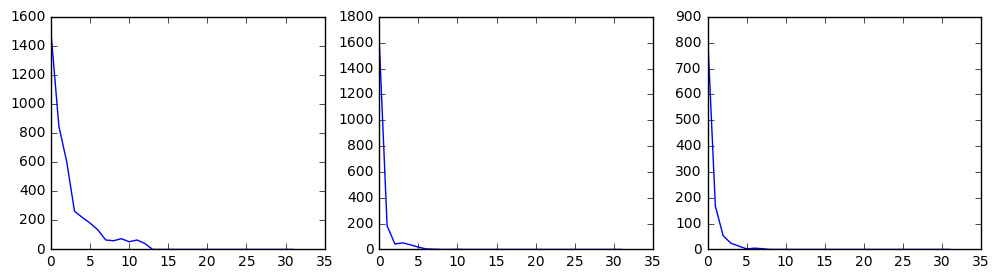

In [314]:
image = get_random_car_image()
# print(np.shape(image))
luv_image = vt.convert_to_LUV(image)
vt.color_channels = [0]
color_hist = vt.get_color_feature(luv_image)
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(color_hist)
vt.color_channels = [1]
color_hist = vt.get_color_feature(luv_image)
plt.subplot(132)
plt.plot(color_hist)
vt.color_channels = [2]
color_hist = vt.get_color_feature(luv_image)
plt.subplot(133)
plt.plot(color_hist)
plt.show()

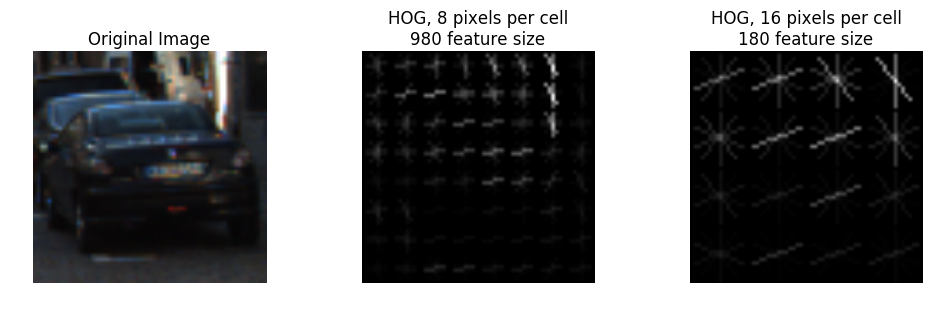

In [315]:
image = get_random_car_image()
luv_image = vt.convert_to_LUV(image)
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
vt.hog_channels = 0
vt.hog_pix = 8
hog_size, hog_image = vt.generate_hog(luv_image, vis=True)
plt.subplot(132)
plt.title("HOG, %i pixels per cell\n%i feature size" % (vt.hog_pix, hog_size))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
vt.hog_pix = 16
hog_size, hog_image = vt.generate_hog(luv_image, vis=True)
plt.subplot(133)
plt.title("HOG, %i pixels per cell\n%i feature size" % (vt.hog_pix, hog_size))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.show()

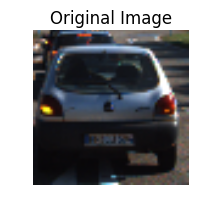

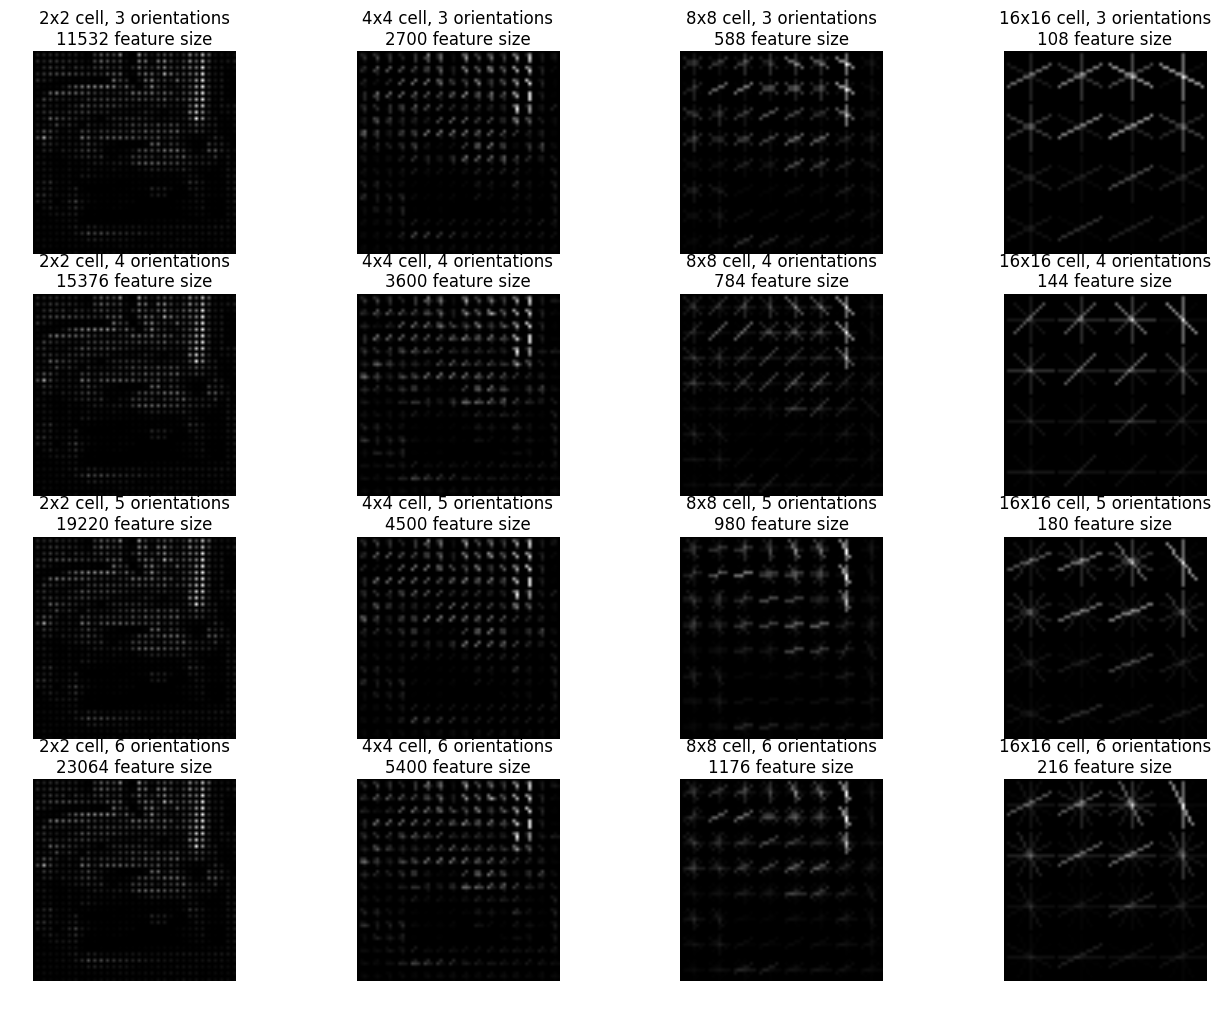

In [316]:
hog_compare_images = []
hog_compare_titles = []

# hog cell sizes to examine
trial_pix_per_cell = [2, 4, 8, 16]
trial_orients = [3, 4, 5, 6]

image = get_random_car_image()
plt.figure(figsize=(12,2))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

vt.hog_channels = 0
vt.hog_cells = 2

for orients in trial_orients:
    vt.hog_orient = orients
    row = []
    for pix in trial_pix_per_cell:
        vt.hog_pix = pix
        hog_size, hog_img = vt.generate_hog(luv_image, vis=True)
        row.append(hog_img)
        hog_compare_titles.append("%ix%i cell, %i orientations\n%i feature size" % 
                                  (vt.hog_pix, vt.hog_pix, vt.hog_orient, hog_size))
    hog_compare_images.append(row)
compare_images(hog_compare_images, hog_compare_titles)

In [392]:
vt = VehicleTracker()
print(vt)
vt.train_classifier('vehicles/', 'non-vehicles/')

Vehicle Detection Parameters
Spatial:	True
  Spatial Size:	(8, 8)
Color:		True
  Channels:	[0, 1, 2]
  Bins:		32
HOG:			True
  Channel:		0
  Orientations:		5
  Pixels per Cell:	8
  Cells per Block:	2
  Sqrt Transform:	False
Window
  Start:	380
  Stop:		670
Classifier:	None
  Size:		(64, 64)
  Heat Threshold: 2
Search Windows:	225
8792 car images
8968 non-car images
Constructing car features... Complete!
Constructing non-car features... Complete!
Normalization Complete.
Data Split Complete
Feature vector length: 1268
Starting Classifier Fit
6.79 Seconds to train SVC...
Test accuracy of classifier =  0.9724
Classifier predictions:	 [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  0.]
For these 10 labels:	 [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  0.]
0.003 seconds to predict 10 labels with classifier.


In [355]:
vt.load_classifier()
print(vt)

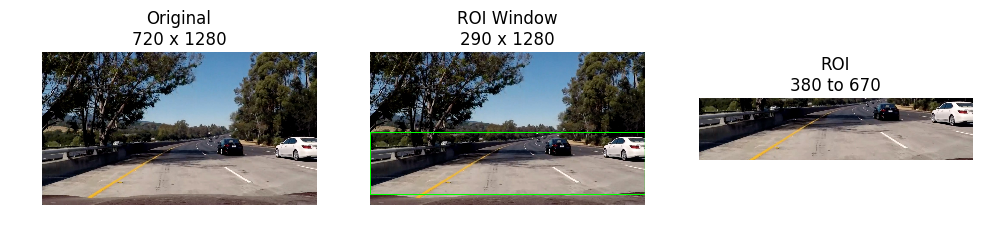

In [373]:
# All
# test_images = read_files('test_images/', 'jpg')

# One
test_images = ['test_images/test5.jpg']

vt.ystart = 380 
vt.ystop = 670
roi_h = vt.ystop-vt.ystart

roi_compare = []
roi_titles = []
for image in test_images:
    row = []
    image = mpimg.imread(image)
    row.append(image)
    draw_roi = np.copy(image)
    img_h, img_w, _ = np.shape(draw_roi)
    cv2.rectangle(draw_roi,(0, vt.ystart),(img_w, vt.ystop),(0,255,0),3)
    row.append(draw_roi)
    roi_image = vt.region_of_interest(image)
    row.append(roi_image)
    roi_compare.append(row)
    roi_titles.append(["Original\n%i x %i" % (img_h, img_w), "ROI Window\n%i x %i" % (roi_h, img_w), "ROI\n%i to %i" % (vt.ystart, vt.ystop)])

roi_titles = np.ravel(roi_titles)
compare_images(roi_compare, roi_titles)

In [301]:
windows = vt.window_gen(0, 1280, 290, 64, 2, windows = [], verbose = True)
print(len(windows), "total search windows.")

14 (290, 290) windows
20 (218, 218) windows
28 (164, 164) windows
39 (123, 123) windows
52 (93, 93) windows
72 (70, 70) windows
225 total search windows.


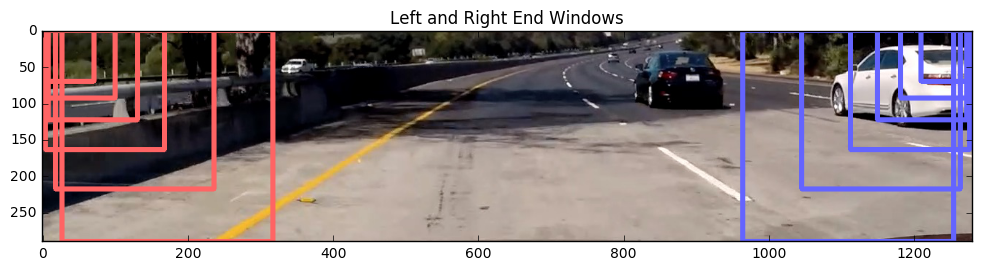

In [438]:
image = mpimg.imread('test_images/test5.jpg')
window_test = vt.region_of_interest(image)
edge_windows = [0]
edge_windows.append(edge_windows[-1]+14)
edge_windows.append(edge_windows[-1]+20)
edge_windows.append(edge_windows[-1]+28)
edge_windows.append(edge_windows[-1]+39)
edge_windows.append(edge_windows[-1]+52)

for i in edge_windows:
    min_corner, max_corner = vt.search_windows[i]
    cv2.rectangle(window_test, min_corner, max_corner, (255, 100, 100), 5)
    min_corner, max_corner = windows[i-1]
    cv2.rectangle(window_test, min_corner, max_corner, (100, 100, 255), 5)
    
figure = plt.figure(figsize=(12,3))
plt.imshow(window_test)
plt.title("Left and Right End Windows")
plt.show()
    

In [357]:
print(vt)

Vehicle Detection Parameters
Spatial:	True
  Spatial Size:	(8, 8)
Color:		True
  Channels:	[0, 1, 2]
  Bins:		32
HOG:			True
  Channel:		0
  Orientations:		5
  Pixels per Cell:	8
  Cells per Block:	2
  Sqrt Transform:	False
Window
  Start:	380
  Stop:		670
Classifier: LinearSVC
  Size:		(64, 64)
  Heat Threshold: 2
Search Windows:	225


In [405]:
vt = VehicleTracker()
vt.load_classifier()
vt.search_image(image)

Classifier Loaded


ValueError: operands could not be broadcast together with shapes (1,4384) (1268,) (1,4384) 

In [437]:
vt = VehicleTracker()
vt.load_classifier()
roi_image = vt.region_of_interest(image)
print(np.shape(image))
print(np.shape(roi_image))
luv_image = vt.convert_to_LUV(roi_image)
print(np.shape(luv_image))
hog_map = vt.generate_hog(luv_image)
print(np.shape(hog_map))
vt.extract_window_features(luv_image, hog_map, vt.search_windows[0])
vt.X_scaler

Classifier Loaded
(720, 1280, 3)
(290, 1280, 3)
(290, 1280, 3)
(35, 159, 2, 2, 5)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


ValueError: operands could not be broadcast together with shapes (92688,) (1268,) (92688,) 

(64, 64, 3)


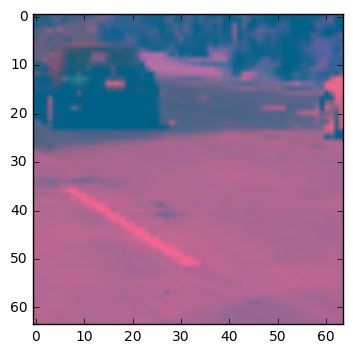

In [433]:
window = vt.search_windows[11]
img_window = cv2.resize(luv_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], vt.clf_size)

print(np.shape(img_window))
plt.imshow(img_window)
plt.show()